El objetivo de este cuaderno es ver el rendimiento del modelo de la neurona MP en un problema real.

El conjunto de datos es de UCI ML Breast Cancer Winsconsin

# **Importamos las dependencias**


In [30]:
# ------ Librerías para Machine Learning (Scikit-learn) ------

from sklearn.datasets import load_breast_cancer      # Se utiliza para cargar el conjunto de datos de cáncer de mama
from sklearn.model_selection import train_test_split # Sirve para dividir un conjunto de datos en dos subconjuntos: uno para entrenamiento y otro para pruebas (test).
from sklearn.metrics import accuracy_score           # Se usa para calcular la precisión (accuracy) de un modelo de clasificación.
from sklearn.metrics import confusion_matrix         # Permite crear una matriz de confusión, una tabla que resume el rendimiento de un modelo de clasificación.


# ------ Librerías para Manipulación y Visualización de Datos ------

import pandas as pd             # Para la manipulación y el análisis de datos. Se utiliza para trabajar con tablas de datos (DataFrames).
import numpy as np              # Esencial para el cálculo numérico en Python, especialmente para trabajar con arrays y matrices.
import matplotlib.pyplot as plt # Se utiliza para crear una amplia variedad de gráficos y visualizaciones de datos.

# ------ Para el manejo de tipos de datos ------
from typing import List, Literal


# **1. Implementación de una MPneuron con más cualidades**

In [34]:
class MPNeuron:
    """
    Implementación del modelo de neurona de McCullonch-Pitts

    Este modelo es un clasificador binario simple. Recibe una serie
    de entradas binarias (0 o 1) y las activa si la suma de estas entradas
    alcanza o supera un umbral predefinido (threshold).

    Tiene el feature de que se escoge de manera automática el mejor threshold
    """

    # Definimos el tipo de datos que va a aceptar el modelo
    estados = Literal[0, 1]

    # Hacemos el constructor
    def __init__(self, threshold: int | None = None):
        """
        Inicializamos la neurona (constructor)
        """
        self.threshold = None


    def model(self, x: List[estados]) -> int:
        """
        Ejecuta el modelo de la neurona para una única entrada.
        
        Args:
            x (List[estados]): Lista de valores (0 y 1)
        
        Returns:
            bool: True si la suma de las entradas es mayor o igual al umbral,
                  False en caso contrario
        """

        if self.threshold is None:
            raise ValueError("El threshold no se a establecido")

        z =sum(x)

        return z >= self.threshold
    

    def predict(self, X: List[List[estados]]) -> np.array:
        """ 
        Realiza predicciones para un conjunto de datos de entrada.

        Args:
            X (List[List[estados]]): Lista de listas de valores de 0 y 1 
                                     (lista de vectores de características)
        
        Returns:
            np.array: Array con los resultados booleanos (True/False)
                      para cada vector de entrada.
        """

        Y = []

        for x in X:
            Y.append(self.model(x))

        return np.array(Y)
    

    def fit(self, X, Y) :
        """ 
        Realiza la búsqueda del mejor threshold

        Args:
            X: Valores de 0 y 1 de la variable independiente
            Y: Valores de la variable independiente
        """

        accuracy = {}

        # El espacio de búsqueda será el número de características de la variable independiente (las columnas)
        for th in range(X.shape[1] + 1):

            self.threshold = th
            Y_pred = self.predict(X)

            # Guardamos en el diccionario el par clave-valor threshold-score
            accuracy[th] = accuracy_score(Y_pred, Y)

        # Obtenemos el mejor threshold (el que tiene asociado el score más alto)
        self.threshold = max(accuracy, key=accuracy.get)

# **2. Carga de los datos**

In [5]:
breast_cancer = load_breast_cancer()

# Vemos las columnas que hay
breast_cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [16]:
# Primero, vemos la descripción del conjunto de datos
print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer Wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

In [ ]:
# Nos interesan las columnas 'data' y 'target'
# pues es en dónde estan los datos de si el paciente
# tiene cancer 'malignant' o 'benign'

# Variable independiente
X = breast_cancer.data

# Variable dependiente
Y = breast_cancer.target

# **3 Preprocessing**

In [12]:
# Transformamos nuestro conjunto de datos en un DataFrame
df = pd.DataFrame(X, columns=breast_cancer.feature_names)
df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

### 3.1 División del conjunto de datos

In [29]:
# Hacemos nuestros conjuntos de datos de entrenamiento y de pruebas
X_train, X_test, y_train, y_test = train_test_split(df, Y, stratify=Y) # stratify trata de mantener las proporciones en train y test con respecto a malignos y benignos

print(f"Tamaño del conjunto de datos de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de datos de pruebas: {len(X_test)}")

Tamaño del conjunto de datos de entrenamiento: 426
Tamaño del conjunto de datos de pruebas: 143


### 3.2 Transformación de datos

Pero, recordemos que este tipo de neurona solo puede recibir datos binarios (0 o 1) y nuestro conjunto de datos tiene valores continuos. Así que para solucionar eso, vamos a transformarlos a binarios

[0, 0, 1, 1, 1, 0, 0]
Categories (2, int64): [0 < 1]


(array([4., 3.]),
 array([0.02, 3.01, 6.  ]),
 <BarContainer object of 2 artists>)

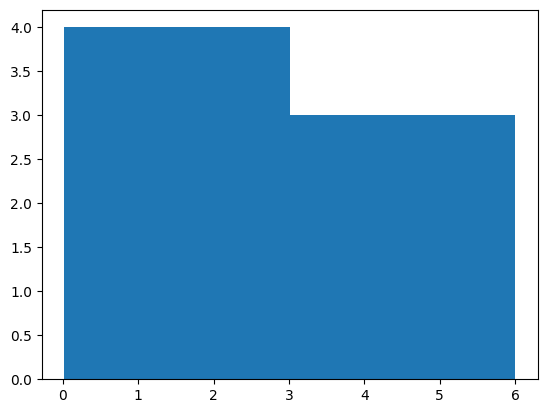

In [35]:
# Usamos pd.cut para poder hacerlo
# Veamos un ejemplo

# 'bins=2' divide los datos en 2 contenedores.
# 'labels=[0, 1]' asigna las etiquetas 0 y 1 a esos contenedores.
print(pd.cut([0.04, 2, 4, 5, 6, 0.02, 0.6], bins=2, labels=[0, 1]))

# Generación del histograma con matplotlib
plt.hist([0.04, 0.3, 4, 5, 6, 0.02, 0.6], bins=2)

In [37]:
# Ahora hacemos lo de la celda anterior pero en nuestros conjuntos de las variables independientes (las X)

X_train_bin = X_train.apply(pd.cut, bins=2, labels=[1, 0])
X_test_bin = X_test.apply(pd.cut, bins=2, labels=[1, 0])

X_train_bin.head(1)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
131,1,1,1,1,0,1,1,1,1,1,...,1,1,1,1,0,1,1,0,1,1


# **Evaluación**

In [ ]:
# Instanciamos la neurona
mp_neuron = MPNeuron()

# Buscamos el threshold óptimo
mp_neuron.fit(X_train_bin.to_numpy(), y_train)

In [42]:
# Vemos cual fué el threshold óptimo
mp_neuron.threshold

27

In [47]:
# Realizamos predicciones para datos nuevos (test)
Y_pred = mp_neuron.predict(X_test_bin.to_numpy())
Y_pred

array([ True,  True,  True,  True, False,  True,  True, False,  True,
       False,  True,  True, False,  True,  True, False,  True,  True,
       False,  True,  True, False, False,  True,  True,  True, False,
       False, False,  True,  True,  True,  True,  True, False, False,
       False,  True, False,  True, False, False,  True,  True,  True,
       False, False, False,  True, False,  True,  True, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False, False,  True, False,  True, False,
        True, False,  True, False,  True, False,  True,  True,  True,
       False, False,  True, False,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
       False, False,

In [48]:
# Evaluamos la predicción
accuracy_score(y_test, Y_pred)

0.8811188811188811

Tenemos un 88.11% de exactitud en la predicción

In [50]:
# Calculamos la matriz de confusión
confusion_matrix(y_test, Y_pred)

array([[46,  7],
       [10, 80]])

In [54]:
# La matriz de confusión
cf_matrix = np.array([[46, 7], [10, 80]])

print("Matriz de Confusión:\n", cf_matrix)
print("\nInterpretación:")
print("VP (Verdaderos Positivos):", cf_matrix[0, 0])
print("FN (Falsos Negativos):", cf_matrix[0, 1])
print("FP (Falsos Positivos):", cf_matrix[1, 0])
print("VN (Verdaderos Negativos):", cf_matrix[1, 1])

Matriz de Confusión:
 [[46  7]
 [10 80]]

Interpretación:
VP (Verdaderos Positivos): 46
FN (Falsos Negativos): 7
FP (Falsos Positivos): 10
VN (Verdaderos Negativos): 80
